In [47]:
import os
import json
import argparse
import pandas as pd
from pymongo import MongoClient
from reportparse.reader.base import BaseReader
from reportparse.annotator.base import BaseAnnotator
from reportparse.util.settings import LAYOUT_NAMES, LEVEL_NAMES
import matplotlib.pyplot as plt
import seaborn as sns
import argparse


# parser = argparse.ArgumentParser(description="Process and analyze climate-related text from a PDF.")
# parser.add_argument("--input", type=str, default="./reportparse/asset/example.pdf", help="Path to input PDF file.")
# parser.add_argument("--output", type=str, default="./cli_results", help="Directory to save output files.")

# args = parser.parse_args()
out= "./cli_results"
os.makedirs(out, exist_ok=True)
inp ="./reportparse/asset/example.pdf"

reader = BaseReader.by_name("pymupdf")()

document = reader.read(input_path=inp)

document = BaseAnnotator.by_name("climate")().annotate(document=document)
document = BaseAnnotator.by_name("climate_commitment")().annotate(document=document)
document = BaseAnnotator.by_name("climate_specificity")().annotate(document=document)

json_output_path = os.path.join(out, os.path.basename(inp) + ".json")
document.save(json_output_path)

df = document.to_dataframe(level="block")
df_2 = document.to_dataframe(level="page")

print(df)

# # eda
print(df.describe())
print()

print(df.info())
print()

print(df.head())
print()

print(df.tail())
print()

print(df.columns)
print()

print(df.index)
print()

climate_df = df[df["climate"] == "yes"]

cti_df = climate_df.groupby("page_id").apply(
    lambda x: pd.Series({
        "commit_total": (x["climate_commitment"] == "yes").sum(),
        "commit_non_spec": ((x["climate_commitment"] == "yes") & (x["climate_specificity"] == "non")).sum()
    })
)

# Calculate CTI
cti_df["CTI"] = cti_df["commit_non_spec"] / cti_df["commit_total"]
cti_df["CTI"].fillna(0, inplace=True)

cti_df.reset_index(inplace=True)

print(cti_df)

# for the whole document
total_commit = (climate_df["climate_commitment"] == "yes").sum()
total_commit_non_spec = ((climate_df["climate_commitment"] == "yes") & (climate_df["climate_specificity"] == "non")).sum()
overall_cti = total_commit_non_spec / total_commit if total_commit > 0 else 0

print(f"Overall Cheap Talk Index (CTI): {overall_cti:.4f}")

cti_results = {
    "page_cti_scores": cti_df.set_index("page_id")["CTI"].to_dict(),
    "overall_cti": overall_cti
}
input_base = os.path.basename(inp)
output_path = f"./cli_results/{input_base}_cti_scrores.json"

with open(output_path, "w") as f:
    json.dump(cti_results, f, indent=4)

print(f"CTI scores saved to {output_path}")


page_ids = list(cti_results["page_cti_scores"].keys())
page_scores = list(cti_results["page_cti_scores"].values())

plt.figure(figsize=(12, 6))

sns.barplot(x=page_ids, y=page_scores, palette="Blues_r")

plt.axhline(y=overall_cti, color='red', linestyle='--', label=f'Overall CTI: {overall_cti:.4f}')

plt.xlabel("Page ID")
plt.ylabel("CTI Score")
plt.title("Cheap Talk Index (CTI) per Page")
plt.xticks(rotation=90)  
plt.legend()

plt.tight_layout()
plt.show()

# save plot in the same dir
plt.savefig(f"./cli_results/{input_base}_cti_plot.png")


ModuleNotFoundError: No module named 'pymongo'

In [ ]:
from logging import getLogger
import traceback
import argparse
import os
import pandas as pd
import ollama
import chromadb
import requests
from reportparse.structure.document import Document
import re
from reportparse.db_rag.db import ChromaDBHandler
from langchain_groq import ChatGroq

logger = getLogger(__name__)


document = Document.from_json_file('example.pdf.json')
df = document.to_dataframe(level='page')
print(df)
print()
print(df.columns)

print()
# print first pass chroma result and web rag result for page 1
page_1 = document.pages[0]
# print(page_1.get_annotation("chroma"))
# print(page_1.get_annotation("web_rag"))

# print the same from df
# print(df.loc[0, "chroma_result"])

      page_id  page_num   page_width  page_height  \
0  page_idx_0         0  4405.499776  4405.499776   
1  page_idx_1         1  4405.499776  4405.499776   
2  page_idx_2         2  4405.499776  4405.499776   
3  page_idx_3         3  4405.499776  4405.499776   
4  page_idx_4         4  4405.499776  4405.499776   
5  page_idx_5         5  4405.499776  4405.499776   

                                           page_text  \
0  049 Hitachi Sustainability Report 2023 Environ...   
1  050 Hitachi Sustainability Report 2023 Environ...   
2  051 Hitachi Sustainability Report 2023 Environ...   
3  052 Hitachi Sustainability Report 2023 Environ...   
4  053 Hitachi Sustainability Report 2023 Environ...   
5  054 Hitachi Sustainability Report 2023 Environ...   

                                          First pass  \
0  Potential greenwashing claim: Hitachi's carbon...   
1  Potential greenwashing claim: Improve water us...   
2  Potential greenwashing claim: Achieving a Deca...   
3  Potentia

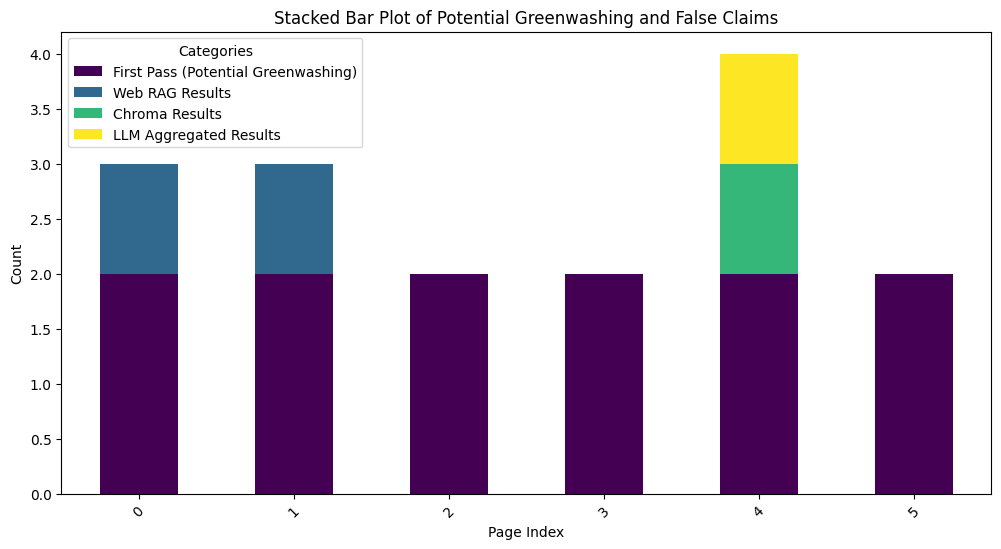

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

first_pass_count = df["First pass"].str.count("Potential greenwashing", flags=re.IGNORECASE).groupby(df.index).sum()

# Define function to count occurrences of "PARTIALLY FALSE" and "FALSE"
def count_false_statements(columns, df):
    return df[columns].apply(lambda col: col.str.contains("Result of the statement: PARTIALLY FALSE|Result of the statement: FALSE", na=False)).sum(axis=1)

web_rag_count = count_false_statements(["web_rag_result", "web_rag_result_2"], df)
chroma_count = count_false_statements(["chroma_result", "chroma_result_2"], df)
llm_agg_count = count_false_statements(["aggregator_result", "aggregator_result_2"], df)

plot_df = pd.DataFrame({
    "First Pass (Potential Greenwashing)": first_pass_count,
    "Web RAG Results": web_rag_count,
    "Chroma Results": chroma_count,
    "LLM Aggregated Results": llm_agg_count
})

ax = plot_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.xlabel("Page Index")
plt.ylabel("Count")
plt.title("Stacked Bar Plot of Potential Greenwashing and False Claims")
plt.legend(title="Categories")
plt.xticks(np.arange(len(plot_df.index)), plot_df.index, rotation=45)
plt.show()


## Confusion matrix 

In [3]:
import pandas as pd
#delete null columns
df = pd.read_csv('experiment1_with_def.csv')
df = df.dropna(axis=1, how='all')
#prepate data for join
df2 = pd.read_csv('Greenwashing_claims_esg_reports.csv')
df2['Type'] = df2['Type'].map(lambda x: 'GREENWASHING' if x == 'greenwash' else 'NOT_GREENWASHING')
#join the dataset
df['ground_truth'] = df['id'].map(df2['Type'])
#df.to_csv('experiment1_with_def_gemini_only.csv', index=False)


In [4]:
#rename label columns
df = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
y_pred = 'aggregator_label'
df = df[df[y_pred].notnull()]
df.loc[df[y_pred].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True), y_pred] = 'GREENWASHING'

#measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
overall_accuracy = accuracy_score(df[y_pred], df['ground_truth'])
print("Overall Accuracy:", np.round(np.round(overall_accuracy,3)*100,3), "%")


labels = df['ground_truth'].unique()

for label in labels:
    correct = ((df[y_pred] == df['ground_truth']) & (df['ground_truth'] == label)).sum()
    total = (df['ground_truth'] == label).sum()
    label_accuracy = (correct / total * 100) if total else 0
    print(f"Accuracy for {label}: {label_accuracy:.2f}%")
    

Overall Accuracy: 81.5 %
Accuracy for GREENWASHING: 84.00%
Accuracy for NOT_GREENWASHING: 79.31%


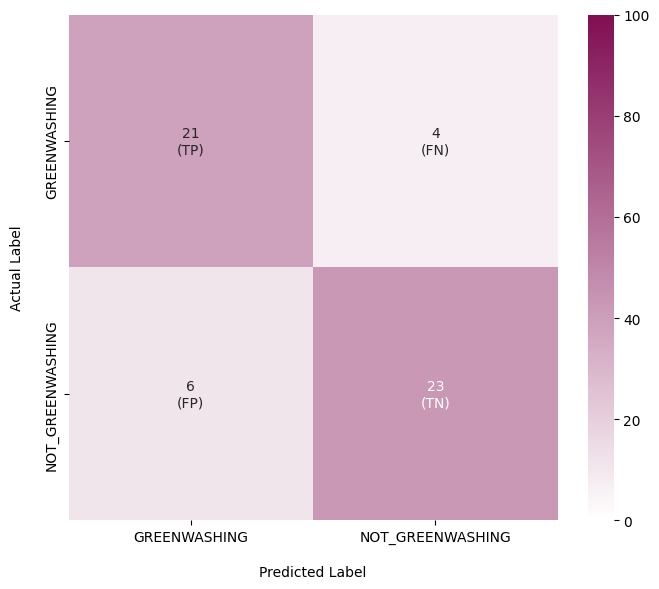

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load your data
df = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
y_pred_col = 'aggregator_label'  # or change to 'news_label', etc.

# Fill NAs
df[[y_pred_col, 'ground_truth']] = df[[y_pred_col, 'ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
df.loc[df[y_pred_col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), y_pred_col] = 'GREENWASHING'

# Calculate confusion matrix components
TP = ((df[y_pred_col] == 'GREENWASHING') & (df['ground_truth'] == 'GREENWASHING')).sum()
FP = ((df[y_pred_col] == 'GREENWASHING') & (df['ground_truth'] == 'NOT_GREENWASHING')).sum()
TN = ((df[y_pred_col] == 'NOT_GREENWASHING') & (df['ground_truth'] == 'NOT_GREENWASHING')).sum()
FN = ((df[y_pred_col] == 'NOT_GREENWASHING') & (df['ground_truth'] == 'GREENWASHING')).sum()

# Build confusion matrix
conf_matrix_counts = np.array([[TN, FP],
                               [FN, TP]])

# Convert to percentages
total = conf_matrix_counts.sum()
conf_matrix_percent = (conf_matrix_counts / total) * 100

# Labels for each cell in confusion matrix order
labels = np.array([["TN", "FP"],
                   ["FN", "TP"]])

# Create annotations with count, percentage and label
annotations = np.empty(conf_matrix_counts.shape, dtype=object)
for i in range(conf_matrix_counts.shape[0]):
    for j in range(conf_matrix_counts.shape[1]):
        annotations[i, j] = f"{conf_matrix_counts[i, j]}\n({labels[i, j]})"

# Define deep purple colormap
deep_purple = (128/255, 14/255, 82/255)
purple_cmap = LinearSegmentedColormap.from_list("purple_cmap", [(1, 1, 1), deep_purple])

# Reverse the order of the labels for both axes
xticklabels = ['GREENWASHING', 'NOT_GREENWASHING']
yticklabels = ['GREENWASHING', 'NOT_GREENWASHING']

# Flip the confusion matrix and annotations to match reversed labels
conf_matrix_percent_reversed = np.flip(np.flip(conf_matrix_percent, axis=0), axis=1)
annotations_reversed = np.flip(np.flip(annotations, axis=0), axis=1)

# Plot the heatmap with reversed axes and annotated counts + percentages + label
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_percent_reversed,
            annot=annotations_reversed,
            fmt='',
            cmap=purple_cmap,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            vmin=0, vmax=100)

plt.xlabel('Predicted Label', labelpad=15)
plt.ylabel('Actual Label', labelpad=15)
plt.tight_layout()
plt.savefig("poster_plots/confusion_matrix_percentages_2.pdf")
plt.show()


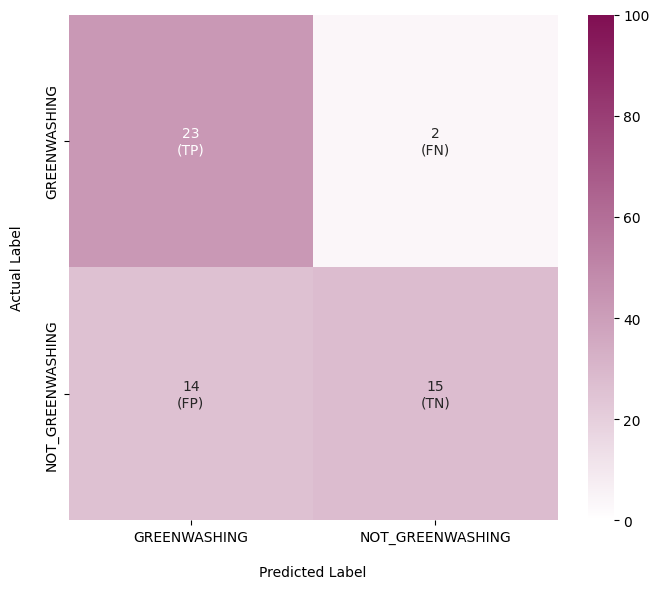

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load your data
df = pd.read_csv('experiment1_with_def.csv')
y_pred_col = 'aggregator_label'  # or change to 'news_label', etc.

# Fill NAs
df[[y_pred_col, 'ground_truth']] = df[[y_pred_col, 'ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
df.loc[df[y_pred_col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), y_pred_col] = 'GREENWASHING'

# Calculate confusion matrix components
TP = ((df[y_pred_col] == 'GREENWASHING') & (df['ground_truth'] == 'GREENWASHING')).sum()
FP = ((df[y_pred_col] == 'GREENWASHING') & (df['ground_truth'] == 'NOT_GREENWASHING')).sum()
TN = ((df[y_pred_col] == 'NOT_GREENWASHING') & (df['ground_truth'] == 'NOT_GREENWASHING')).sum()
FN = ((df[y_pred_col] == 'NOT_GREENWASHING') & (df['ground_truth'] == 'GREENWASHING')).sum()

# Build confusion matrix
conf_matrix_counts = np.array([[TN, FP],
                               [FN, TP]])

# Convert to percentages
total = conf_matrix_counts.sum()
conf_matrix_percent = (conf_matrix_counts / total) * 100

# Labels for each cell in confusion matrix order
labels = np.array([["TN", "FP"],
                   ["FN", "TP"]])

# Create annotations with count, percentage and label
annotations = np.empty(conf_matrix_counts.shape, dtype=object)
for i in range(conf_matrix_counts.shape[0]):
    for j in range(conf_matrix_counts.shape[1]):
        annotations[i, j] = f"{conf_matrix_counts[i, j]}\n({labels[i, j]})"

# Define deep purple colormap
deep_purple = (128/255, 14/255, 82/255)
purple_cmap = LinearSegmentedColormap.from_list("purple_cmap", [(1, 1, 1), deep_purple])

# Reverse the order of the labels for both axes
xticklabels = ['GREENWASHING', 'NOT_GREENWASHING']
yticklabels = ['GREENWASHING', 'NOT_GREENWASHING']

# Flip the confusion matrix and annotations to match reversed labels
conf_matrix_percent_reversed = np.flip(np.flip(conf_matrix_percent, axis=0), axis=1)
annotations_reversed = np.flip(np.flip(annotations, axis=0), axis=1)

# Plot the heatmap with reversed axes and annotated counts + percentages + label
plt.figure(figsize=(7, 6))
sns.heatmap(conf_matrix_percent_reversed,
            annot=annotations_reversed,
            fmt='',
            cmap=purple_cmap,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            vmin=0, vmax=100)

plt.xlabel('Predicted Label', labelpad=15)
plt.ylabel('Actual Label', labelpad=15)
plt.tight_layout()
plt.savefig("poster_plots/confusion_matrix_percentages.pdf")
plt.show()


In [7]:
df2 = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
df1 = pd.read_csv('experiment1_with_def.csv')


# Ensure both 'id' columns are clean and of integer type
ids_df1 = pd.Index(df1['id'].dropna().astype(int).unique())
ids_df2 = pd.Index(df2['id'].dropna().astype(int).unique())

# IDs in df1 but not in df2
ids_in_df1_not_df2 = ids_df1.difference(ids_df2)

# IDs in df2 but not in df1
ids_in_df2_not_df1 = ids_df2.difference(ids_df1)

print("IDs in df1 but not in df2:")
print(ids_in_df1_not_df2.tolist())

print("IDs in df2 but not in df1:")
print(ids_in_df2_not_df1.tolist())


IDs in df1 but not in df2:
[]
IDs in df2 but not in df1:
[]


In [8]:
df2 = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
df1 = pd.read_csv('experiment1_with_def.csv')


# Merge correct values from df1 into df2 based on the 'claim' column
df2_updated = df2.drop(columns=['id', 'ground_truth'], errors='ignore')  # remove existing wrong cols
df2_updated = df2_updated.merge(df1[['Claim', 'id', 'ground_truth']], on='Claim', how='left')

# Save to CSV
#df2_updated.to_csv('final_aggregation_without_intermediate_steps_2.csv', index=False)


### Barplots with and without UNCLEAR label

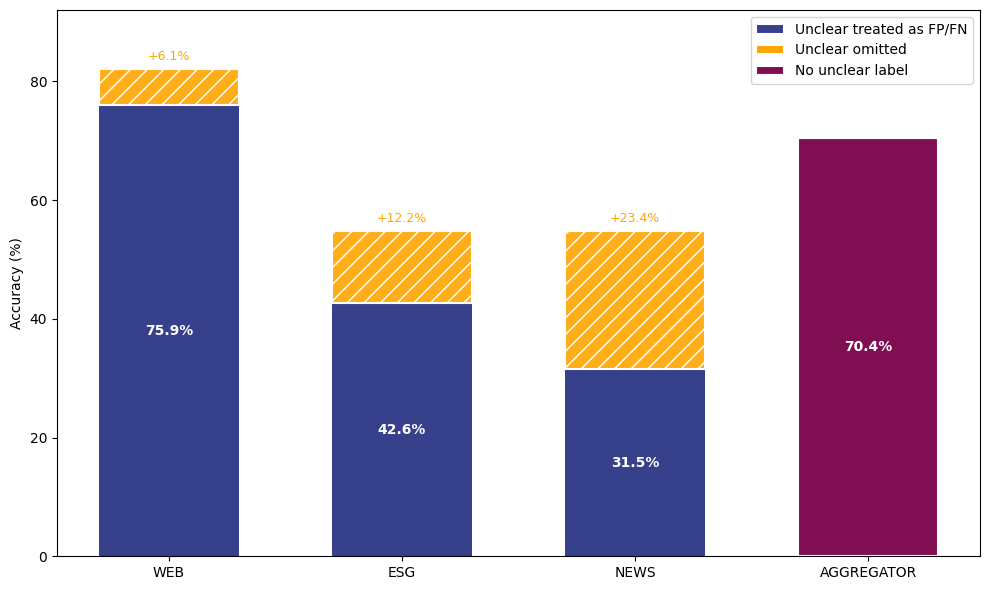

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib import patches as mpatches

# Step 1: Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Step 2: Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Step 3: Collect scores
base_accuracies = []  # with UNCLEAR
deltas = []           # improvement after removing UNCLEAR

for col in y_pred:
    acc_with = accuracy_score(df['ground_truth'], df[col])
    df_filtered = df[df[col] != 'UNCLEAR']
    acc_without = accuracy_score(df_filtered['ground_truth'], df_filtered[col])
    
    base_accuracies.append(acc_with * 100)
    deltas.append((acc_without - acc_with) * 100)

# Step 4: Reverse the order
y_pred = y_pred[::-1]
base_accuracies = base_accuracies[::-1]
deltas = deltas[::-1]

# Plotting
x = range(len(y_pred))
width = 0.6

# Colors
base_color = (128/255, 14/255, 82/255)        # deep purple
delta_color = 'orange'      
non_aggregator_color = (55/255, 64/255, 138/255)  # blue for non-aggregator base bars

fig, ax = plt.subplots(figsize=(10, 6))

bars = []
for i in x:
    is_aggregator = (i == len(y_pred) - 1)
    color = base_color if is_aggregator else non_aggregator_color
    hatch = None
    edgecolor = 'white' if is_aggregator else None
    linewidth = 1.5 if is_aggregator else 0

    bar = ax.bar(
        i, base_accuracies[i], width=width,
        color=color, hatch=hatch, edgecolor=edgecolor, linewidth=linewidth
    )
    bars.append(bar[0])

# Delta bars (stacked)
delta_bars = ax.bar(
    x, deltas, width=width, bottom=base_accuracies,
    color=delta_color, alpha=0.9
)

# Optional hatch overlay on top of delta bars for style
ax.bar(
    x, deltas, width=width, bottom=base_accuracies,
    facecolor='none', edgecolor='white', hatch='//', linewidth=1.5
)

# Annotations
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='orange')

# Custom legend patches
legend_patches = [
    mpatches.Patch(
        facecolor=non_aggregator_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear treated as FP/FN'
    ),
    mpatches.Patch(
        facecolor=delta_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear omitted'
    ),
    mpatches.Patch(
        facecolor=base_color,
        edgecolor='white',
        linewidth=1.5,
        label='No unclear label'
    )
]


ax.set_xticks(list(x))
ax.set_xticklabels(['WEB', 'ESG', 'NEWS', 'AGGREGATOR'])  # reversed labels
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_accuracies, deltas)]) + 10)
ax.legend(handles=legend_patches, title="")



plt.tight_layout()
plt.savefig("poster_plots/accuracy_by_label_source.pdf")
plt.show()


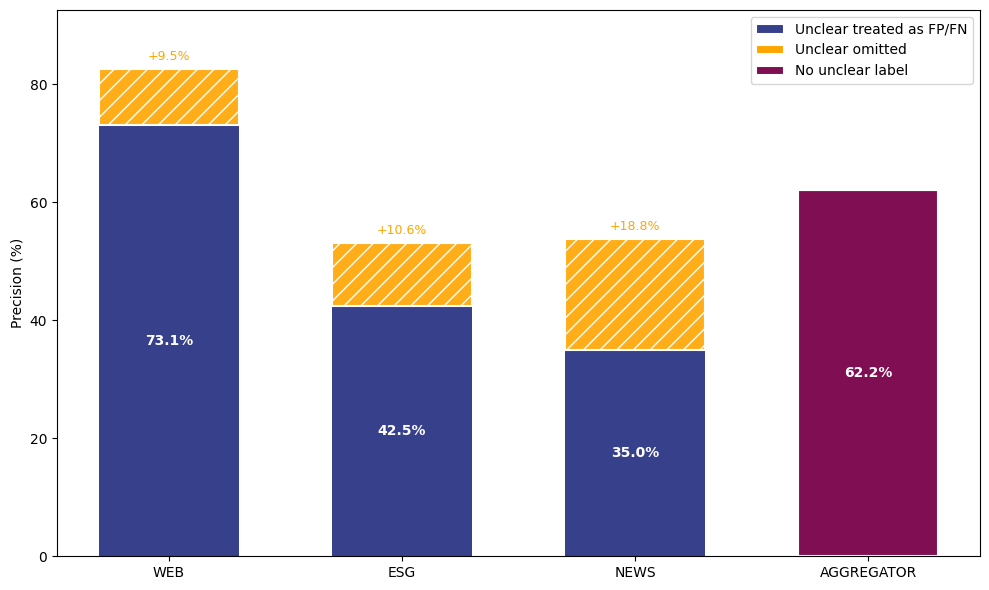

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from matplotlib import patches as mpatches

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Custom precision function with UNCLEAR handling
def precision_with_unclear(y_true, y_pred):
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]
    y_pred_bin = []
    for t, p in zip(y_true_bin, y_pred):
        if p == 'GREENWASHING':
            y_pred_bin.append(1)
        elif p == 'UNCLEAR':
            y_pred_bin.append(0 if t == 1 else 1)
        else:
            y_pred_bin.append(0)
    return precision_score(y_true_bin, y_pred_bin, zero_division=0) * 100

# Calculate precision scores with and without UNCLEAR
base_precisions = []
deltas = []

for col in y_pred:
    prec_with_unclear = precision_with_unclear(df['ground_truth'], df[col])
    
    df_filtered = df[df[col] != 'UNCLEAR']
    prec_without_unclear = precision_score(
        [1 if y == 'GREENWASHING' else 0 for y in df_filtered['ground_truth']],
        [1 if p == 'GREENWASHING' else 0 for p in df_filtered[col]],
        zero_division=0
    ) * 100
    
    base_precisions.append(prec_with_unclear)
    deltas.append(prec_without_unclear - prec_with_unclear)

# Reverse the order of everything
y_pred = y_pred[::-1]
base_precisions = base_precisions[::-1]
deltas = deltas[::-1]

# Plotting
x = range(len(y_pred))
width = 0.6

# Colors
base_color = (128/255, 14/255, 82/255)        # deep purple
delta_color = 'orange'      
non_aggregator_color = (55/255, 64/255, 138/255)  # blue for non-aggregator base bars

fig, ax = plt.subplots(figsize=(10, 6))

bars = []
for i in x:
    is_aggregator = (i == len(y_pred) - 1)
    color = base_color if is_aggregator else non_aggregator_color
    hatch = None
    edgecolor = 'white' if is_aggregator else None
    linewidth = 1.5 if is_aggregator else 0

    bar = ax.bar(
        i, base_precisions[i], width=width,
        color=color, hatch=hatch, edgecolor=edgecolor, linewidth=linewidth
    )
    bars.append(bar[0])

# Delta bars (stacked)
delta_bars = ax.bar(
    x, deltas, width=width, bottom=base_precisions,
    color=delta_color, alpha=0.9
)

# Optional hatch overlay on top of delta bars for style
ax.bar(
    x, deltas, width=width, bottom=base_precisions,
    facecolor='none', edgecolor='white', hatch='//', linewidth=1.5
)

# Annotations
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='orange')

# Custom legend patches
legend_patches = [
    mpatches.Patch(
        facecolor=non_aggregator_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear treated as FP/FN'
    ),
    mpatches.Patch(
        facecolor=delta_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear omitted'
    ),
    mpatches.Patch(
        facecolor=base_color,
        edgecolor='white',
        linewidth=1.5,
        label='No unclear label'
    )
]


ax.set_xticks(list(x))
ax.set_xticklabels(['WEB', 'ESG', 'NEWS', 'AGGREGATOR'])  # reversed labels
ax.set_ylabel("Precision (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_precisions, deltas)]) + 10)
ax.legend(handles=legend_patches, title="")


plt.tight_layout()
plt.savefig("poster_plots/precision_by_label_source.pdf")
plt.show()


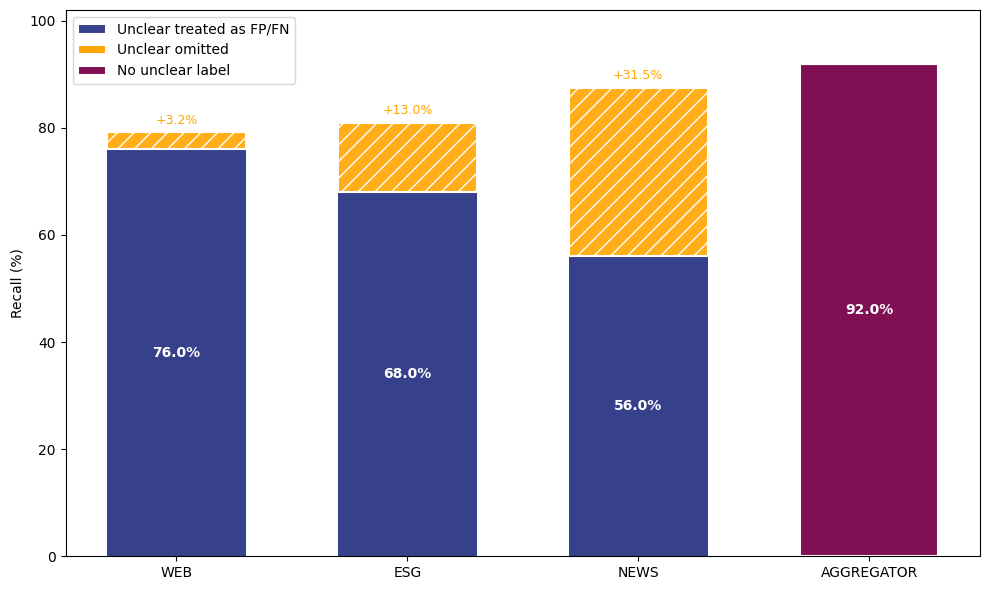

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Custom recall function with UNCLEAR handling
def recall_with_unclear(y_true, y_pred):
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]
    y_pred_bin = []
    for t, p in zip(y_true_bin, y_pred):
        if p == 'GREENWASHING':
            y_pred_bin.append(1)
        elif p == 'UNCLEAR':
            y_pred_bin.append(0)  # always predict 0 on UNCLEAR for recall
        else:
            y_pred_bin.append(0)
    return recall_score(y_true_bin, y_pred_bin, zero_division=0) * 100

# Calculate recall scores with and without UNCLEAR
base_recalls = []
deltas = []

for col in y_pred:
    rec_with_unclear = recall_with_unclear(df['ground_truth'], df[col])
    
    df_filtered = df[df[col] != 'UNCLEAR']
    rec_without_unclear = recall_score(
        [1 if y == 'GREENWASHING' else 0 for y in df_filtered['ground_truth']],
        [1 if p == 'GREENWASHING' else 0 for p in df_filtered[col]],
        zero_division=0
    ) * 100
    
    base_recalls.append(rec_with_unclear)
    deltas.append(rec_without_unclear - rec_with_unclear)

# Reverse order for plotting
y_pred = y_pred[::-1]
base_recalls = base_recalls[::-1]
deltas = deltas[::-1]

import matplotlib.patches as mpatches

# Plotting
x = range(len(y_pred))
width = 0.6

# Colors
base_color = (128/255, 14/255, 82/255)        # deep purple
delta_color = 'orange'      
non_aggregator_color = (55/255, 64/255, 138/255)  # blue for non-aggregator base bars

fig, ax = plt.subplots(figsize=(10, 6))

bars = []
for i in x:
    is_aggregator = (i == len(y_pred) - 1)
    color = base_color if is_aggregator else non_aggregator_color
    hatch = None
    edgecolor = 'white' if is_aggregator else None
    linewidth = 1.5 if is_aggregator else 0

    bar = ax.bar(
        i, base_recalls[i], width=width,
        color=color, hatch=hatch, edgecolor=edgecolor, linewidth=linewidth
    )
    bars.append(bar[0])

# Delta bars (stacked)
delta_bars = ax.bar(
    x, deltas, width=width, bottom=base_recalls,
    color=delta_color, alpha=0.9
)

# Optional hatch overlay on top of delta bars for style
ax.bar(
    x, deltas, width=width, bottom=base_recalls,
    facecolor='none', edgecolor='white', hatch='//', linewidth=1.5
)

# Annotations
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='orange')

# Custom legend patches
legend_patches = [
    mpatches.Patch(
        facecolor=non_aggregator_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear treated as FP/FN'
    ),
    mpatches.Patch(
        facecolor=delta_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear omitted'
    ),
    mpatches.Patch(
        facecolor=base_color,
        edgecolor='white',
        linewidth=1.5,
        label='No unclear label'
    )
]


ax.set_xticks(list(x))
ax.set_xticklabels(['WEB', 'ESG', 'NEWS', 'AGGREGATOR'])  # reversed labels
ax.set_ylabel("Recall (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_recalls, deltas)]) + 10)
ax.legend(handles=legend_patches, title="", loc='upper left')

plt.tight_layout()
plt.savefig("poster_plots/recall_by_label_source.pdf")
plt.show()


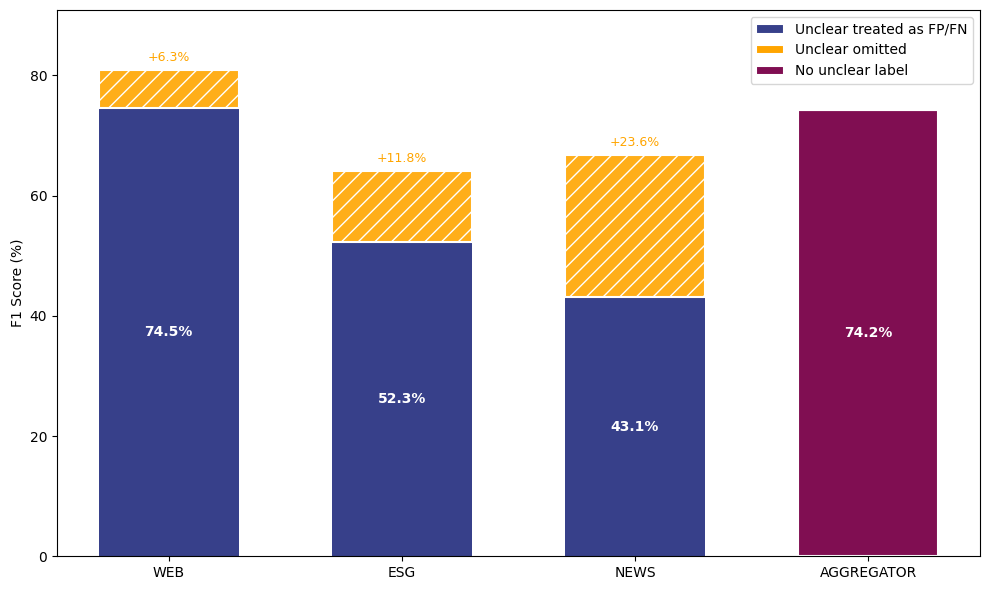

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Custom F1 function with UNCLEAR handling
def f1_with_unclear(y_true, y_pred):
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]

    y_pred_bin = []
    for t, p in zip(y_true_bin, y_pred):
        if p == 'GREENWASHING':
            y_pred_bin.append(1)
        elif p == 'UNCLEAR':
            y_pred_bin.append(0 if t == 1 else 1)
        else:
            y_pred_bin.append(0)

    return f1_score(y_true_bin, y_pred_bin, zero_division=0) * 100

# Calculate F1 scores with and without UNCLEAR
base_f1s = []
deltas = []

for col in y_pred:
    f1_with = f1_with_unclear(df['ground_truth'], df[col])

    df_filtered = df[df[col] != 'UNCLEAR']
    f1_without = f1_score(
        [1 if y == 'GREENWASHING' else 0 for y in df_filtered['ground_truth']],
        [1 if p == 'GREENWASHING' else 0 for p in df_filtered[col]],
        zero_division=0
    ) * 100

    base_f1s.append(f1_with)
    deltas.append(f1_without - f1_with)

# Reverse order for plotting
y_pred = y_pred[::-1]
base_f1s = base_f1s[::-1]
deltas = deltas[::-1]

import matplotlib.patches as mpatches

# Plotting
x = range(len(y_pred))
width = 0.6

# Colors
base_color = (128/255, 14/255, 82/255)        # deep purple
delta_color = 'orange'      
non_aggregator_color = (55/255, 64/255, 138/255)  # blue for non-aggregator base bars

fig, ax = plt.subplots(figsize=(10, 6))

bars = []
for i in x:
    is_aggregator = (i == len(y_pred) - 1)
    color = base_color if is_aggregator else non_aggregator_color
    hatch = None
    edgecolor = 'white' if is_aggregator else None
    linewidth = 1.5 if is_aggregator else 0

    bar = ax.bar(
        i, base_f1s[i], width=width,
        color=color, hatch=hatch, edgecolor=edgecolor, linewidth=linewidth
    )
    bars.append(bar[0])

# Delta bars (stacked)
delta_bars = ax.bar(
    x, deltas, width=width, bottom=base_f1s,
    color=delta_color, alpha=0.9
)

# Optional hatch overlay on top of delta bars for style
ax.bar(
    x, deltas, width=width, bottom=base_f1s,
    facecolor='none', edgecolor='white', hatch='//', linewidth=1.5
)

# Annotations
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height * 0.5, f"{height:.1f}%", 
            ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if delta > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height + delta + 1, f"+{delta:.1f}%", 
                ha='center', va='bottom', fontsize=9, color='orange')

# Custom legend patches
legend_patches = [
    mpatches.Patch(
        facecolor=non_aggregator_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear treated as FP/FN'
    ),
    mpatches.Patch(
        facecolor=delta_color,
        edgecolor='white',
        linewidth=1.5,
        label='Unclear omitted'
    ),
    mpatches.Patch(
        facecolor=base_color,
        edgecolor='white',
        linewidth=1.5,
        label='No unclear label'
    )
]


ax.set_xticks(list(x))
ax.set_xticklabels(['WEB', 'ESG', 'NEWS', 'AGGREGATOR'])  # reversed labels
ax.set_ylabel("F1 Score (%)")
ax.set_ylim(0, max([b + d for b, d in zip(base_f1s, deltas)]) + 10)
ax.legend(handles=legend_patches, title="")

plt.tight_layout()
plt.savefig("poster_plots/f1_by_label_source.pdf")
plt.show()



In [13]:
import pandas as pd
from collections import Counter

# Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

def confusion_counts(y_true, y_pred):
    """
    Returns counts of TP, FP, FN, TN with the custom UNCLEAR handling:
    - UNCLEAR predicted counts as:
      * FN if true label is GREENWASHING (missed positive)
      * FP if true label is NOT GREENWASHING (wrong positive)
    """
    counts = Counter({'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0})

    for t, p in zip(y_true, y_pred):
        # Convert to binary
        t_bin = 1 if t == 'GREENWASHING' else 0
        
        # Handle prediction
        if p == 'GREENWASHING':
            p_bin = 1
        elif p == 'UNCLEAR':
            # UNCLEAR counts as FN if true positive, else FP
            if t_bin == 1:
                counts['FN'] += 1
                continue
            else:
                counts['FP'] += 1
                continue
        else:
            p_bin = 0
        
        # Increment counts
        if p_bin == 1 and t_bin == 1:
            counts['TP'] += 1
        elif p_bin == 1 and t_bin == 0:
            counts['FP'] += 1
        elif p_bin == 0 and t_bin == 1:
            counts['FN'] += 1
        elif p_bin == 0 and t_bin == 0:
            counts['TN'] += 1

    return counts

print("Confusion matrix counts with UNCLEAR included:")
for col in y_pred:
    counts = confusion_counts(df['ground_truth'], df[col])
    print(f"{col}: {dict(counts)}")

print("\nConfusion matrix counts with UNCLEAR removed:")
for col in y_pred:
    filtered_df = df[df[col] != 'UNCLEAR']
    y_true_bin = ['GREENWASHING' if x == 'GREENWASHING' else 'NOT GREENWASHING' for x in filtered_df['ground_truth']]
    y_pred_bin = filtered_df[col]

    counts = Counter({'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0})
    for t, p in zip(y_true_bin, y_pred_bin):
        t_bin = 1 if t == 'GREENWASHING' else 0
        p_bin = 1 if p == 'GREENWASHING' else 0

        if p_bin == 1 and t_bin == 1:
            counts['TP'] += 1
        elif p_bin == 1 and t_bin == 0:
            counts['FP'] += 1
        elif p_bin == 0 and t_bin == 1:
            counts['FN'] += 1
        elif p_bin == 0 and t_bin == 0:
            counts['TN'] += 1

    print(f"{col}: {dict(counts)}")





Confusion matrix counts with UNCLEAR included:
aggregator_label: {'TP': 23, 'FP': 14, 'FN': 2, 'TN': 15}
news_label: {'TP': 14, 'FP': 26, 'FN': 11, 'TN': 3}
chroma_label: {'TP': 17, 'FP': 23, 'FN': 8, 'TN': 6}
web_rag_label: {'TP': 19, 'FP': 7, 'FN': 6, 'TN': 22}

Confusion matrix counts with UNCLEAR removed:
aggregator_label: {'TP': 23, 'FP': 14, 'FN': 2, 'TN': 15}
news_label: {'TP': 14, 'FP': 12, 'FN': 2, 'TN': 3}
chroma_label: {'TP': 17, 'FP': 15, 'FN': 4, 'TN': 6}
web_rag_label: {'TP': 19, 'FP': 4, 'FN': 5, 'TN': 22}


### Create a plot measuring performance with intermediate RAGs vs non indermediate RAGs

In [1]:
import pandas as pd
df = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
df2 = pd.read_csv('Greenwashing_claims_esg_reports.csv')
df2['Type'] = df2['Type'].map(lambda x: 'GREENWASHING' if x == 'greenwash' else 'NOT_GREENWASHING')
#join the dataset
df['ground_truth'] = df['id'].map(df2['Type'])
#df.to_csv('final_aggregation_without_intermediate_steps.csv', index=False)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Load the dataset
df = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
# List of prediction columns to evaluate
y_pred_cols = ['aggregator_label']
# Ground truth column
y_true_col = 'ground_truth'
# Results storage
metrics_data = []
# Calculate metrics for each y_pred column
for col in y_pred_cols:
    if col not in df.columns:
        continue  # skip if column doesn't exist

    # Drop rows with null in either ground truth or y_pred
    temp_df = df[[y_true_col, col]].dropna()

    # Optional: normalize GREENWASHING TYPE labels (only for specific columns if needed)
    if col in y_pred_cols:
        temp_df.loc[temp_df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True), col] = 'GREENWASHING'
        #temp_df = temp_df[temp_df[col] != 'UNCLEAR']
        
    y_true = temp_df[y_true_col]
    y_pred = temp_df[col]

 

    metrics_data.append({
        'Label Source': "Pipeline B",
        'Metric': 'Accuracy',
        'Score': accuracy_score(y_true, y_pred) * 100
    })
    metrics_data.append({
        'Label Source': "Pipeline B",
        'Metric': 'Precision',
        'Score': precision_score(y_true, y_pred,  pos_label='GREENWASHING', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': "Pipeline B",
        'Metric': 'Recall',
        'Score': recall_score(y_true, y_pred, pos_label='GREENWASHING', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': "Pipeline B",
        'Metric': 'F1 Score',
        'Score': f1_score(y_true, y_pred,pos_label='GREENWASHING', zero_division=0) * 100
    })







In [3]:
# Load the dataset
df = pd.read_csv('experiment1_with_def.csv')
# List of prediction columns to evaluate
y_pred_cols = ['aggregator_label']
# Ground truth column
y_true_col = 'ground_truth'
# Results storage
#metrics_data = []
# Calculate metrics for each y_pred column
for col in y_pred_cols:
    if col not in df.columns:
        continue  # skip if column doesn't exist

    # Drop rows with null in either ground truth or y_pred
    temp_df = df[[y_true_col, col]].dropna()

    # Optional: normalize GREENWASHING TYPE labels (only for specific columns if needed)
    if col in y_pred_cols:
        temp_df.loc[temp_df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True), col] = 'GREENWASHING'
        temp_df2 = temp_df[temp_df[col] != 'UNCLEAR']
        
    y_true = temp_df[y_true_col]
    y_pred = temp_df[col]

    y_true2 = temp_df2[y_true_col]
    y_pred2 = temp_df2[col]

    metrics_data.append({
        'Label Source': "Pipeline A",
        'Metric': 'Accuracy',
        'Score': accuracy_score(y_true, y_pred) * 100
    })
    metrics_data.append({
        'Label Source': "Pipeline A",
        'Metric': 'Precision',
        'Score': precision_score(y_true, y_pred,pos_label='GREENWASHING', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': "Pipeline A",
        'Metric': 'Recall',
        'Score': recall_score(y_true, y_pred, pos_label='GREENWASHING', zero_division=0) * 100
    })
    metrics_data.append({
        'Label Source': "Pipeline A",
        'Metric': 'F1 Score',
        'Score': f1_score(y_true, y_pred,pos_label='GREENWASHING',  zero_division=0) * 100
    })



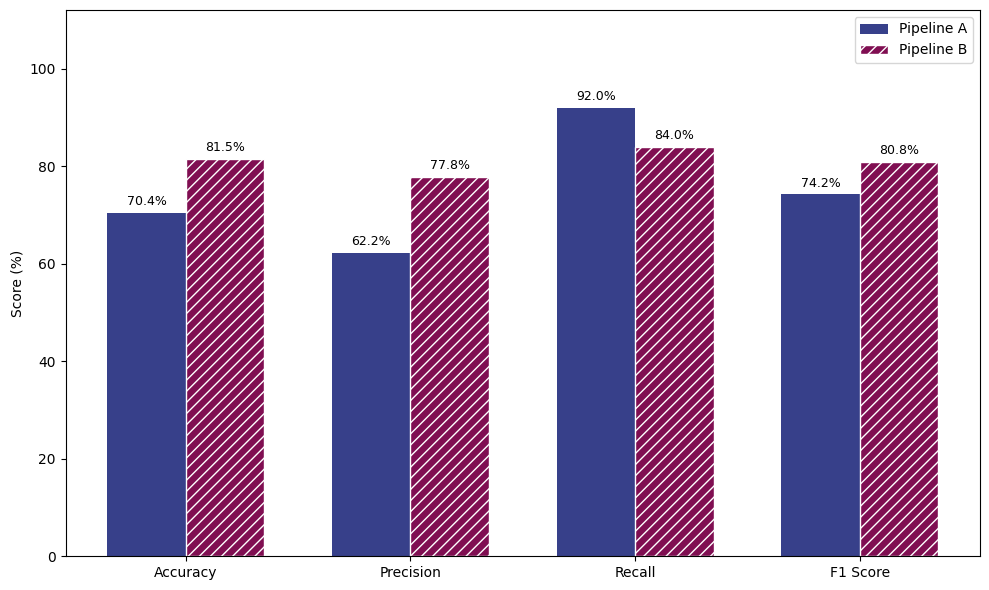

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume metrics_df is already defined
metrics_df = pd.DataFrame(metrics_data)
metric_order = ["Accuracy", "Precision", "Recall", "F1 Score"]
pivot_df = metrics_df.pivot(index="Metric", columns="Label Source", values="Score").loc[metric_order]

# Get the two label sources
cols = pivot_df.columns.tolist()
without_col = [c for c in cols if "A" in c][0]
with_col = [c for c in cols if "B" in c][0]

x = range(len(pivot_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Define colors
color_a = (55/255, 64/255, 138/255)     # Deep blue
color_b = (128/255, 14/255, 82/255)     # Deep purple

# Plot both bars side by side
bar1 = ax.bar([i - width / 2 for i in x], pivot_df[without_col], width=width, label=without_col, color=color_a)
bar2 = ax.bar(
    [i + width / 2 for i in x], 
    pivot_df[with_col], 
    width=width, 
    label=with_col, 
    color=color_b,           # fill color purple
    edgecolor='white',       # white hatch lines
    hatch='///'              # hatch pattern
)
# Annotate values
for i in x:
    y1 = pivot_df.iloc[i][without_col]
    y2 = pivot_df.iloc[i][with_col]
    ax.text(i - width / 2, y1 + 1, f"{y1:.1f}%", ha='center', va='bottom', fontsize=9)
    ax.text(i + width / 2, y2 + 1, f"{y2:.1f}%", ha='center', va='bottom', fontsize=9)

# Styling
ax.set_xticks(list(x))
ax.set_xticklabels(metric_order)
ax.set_ylabel("Score (%)")
ax.set_ylim(0, max(pivot_df.max()) + 20)
ax.legend(title="")

plt.tight_layout()
plt.savefig("poster_plots/performance_comparison.pdf")
plt.show()


## Creating barplots for the RAG pipelines

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load and preprocess
df = pd.read_csv('experiment1_with_def.csv')
y_pred = ['aggregator_label', 'news_label', 'chroma_label', 'web_rag_label']
df[y_pred + ['ground_truth']] = df[y_pred + ['ground_truth']].fillna('UNCLEAR')

# Step 2: Normalize greenwashing labels
for col in y_pred:
    df.loc[df[col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), col] = 'GREENWASHING'

# Step 3: Collect metrics
metrics_with = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}
metrics_without = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}

for col in y_pred:
    # With UNCLEAR
    metrics_with['Accuracy'].append(accuracy_score(df['ground_truth'], df[col]) * 100)
    metrics_with['Precision'].append(precision_score(df['ground_truth'], df[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_with['Recall'].append(recall_score(df['ground_truth'], df[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_with['F1'].append(f1_score(df['ground_truth'], df[col], pos_label='GREENWASHING', zero_division=0) * 100)

    # Without UNCLEAR
    df_filtered = df[df[col] != 'UNCLEAR']
    metrics_without['Accuracy'].append(accuracy_score(df_filtered['ground_truth'], df_filtered[col]) * 100)
    metrics_without['Precision'].append(precision_score(df_filtered['ground_truth'], df_filtered[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_without['Recall'].append(recall_score(df_filtered['ground_truth'], df_filtered[col], pos_label='GREENWASHING', zero_division=0) * 100)
    metrics_without['F1'].append(f1_score(df_filtered['ground_truth'], df_filtered[col], pos_label='GREENWASHING', zero_division=0) * 100)

# Step 4: Plot grouped bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
n_models = len(y_pred)
n_metrics = len(metrics)
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))

# Plot for each metric
for i, metric in enumerate(metrics):
    offset = i - (n_metrics - 1) / 2  # spacing around model index
    x = [j + offset * width for j in range(n_models)]

    ax.bar(x, metrics_with[metric], width=width, label=f'{metric} (with UNCLEAR)', alpha=0.6)
    ax.bar(x, metrics_without[metric], width=width, label=f'{metric} (without UNCLEAR)', alpha=0.9)

    # Annotate top values
    for j in range(n_models):
        ax.text(x[j], metrics_without[metric][j] + 1, f"{metrics_without[metric][j]:.1f}%", ha='center', va='bottom', fontsize=8)

# Styling
ax.set_xticks(range(n_models))
ax.set_xticklabels(y_pred)
ax.set_ylabel("Score (%)")
ax.set_ylim(0, 110)
ax.set_title("Evaluation Metrics per Label Source (With vs Without UNCLEAR)", fontsize=14, weight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

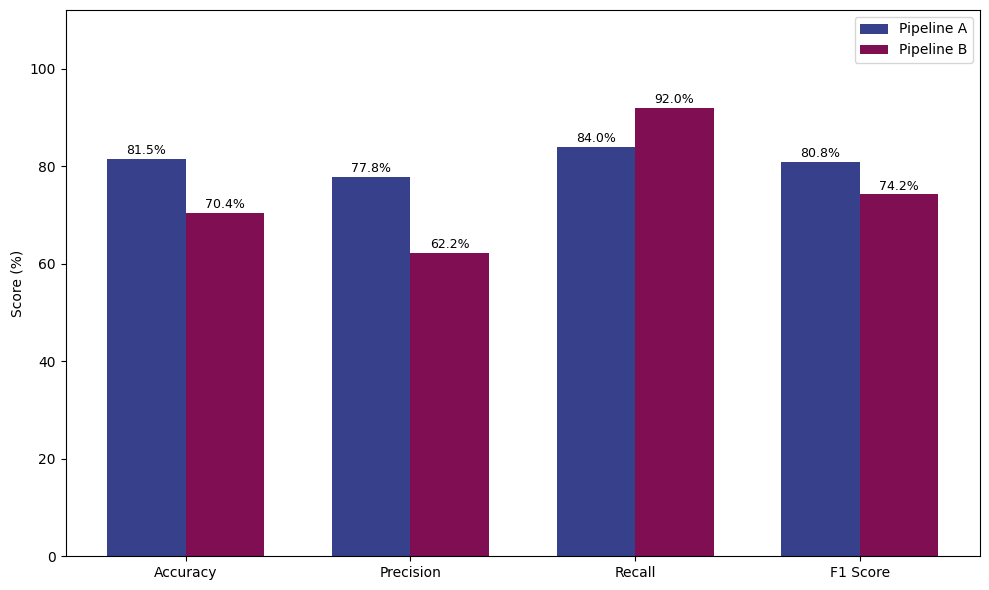

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load Pipeline A data (final aggregation)
df_a = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')

# Load Pipeline B data (experiment data with UNCLEAR handling)
df_b = pd.read_csv('experiment1_with_def.csv')

# Common prediction and ground truth columns
pred_col = 'aggregator_label'
true_col = 'ground_truth'

# Fill NaNs with 'UNCLEAR' in Pipeline B dataset
df_b[[pred_col, true_col]] = df_b[[pred_col, true_col]].fillna('UNCLEAR')

# Normalize GREENWASHING TYPE labels in Pipeline B as in your previous logic
df_b.loc[df_b[pred_col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), pred_col] = 'GREENWASHING'

# For Pipeline A, assume no UNCLEAR labels or treat UNCLEAR as 0 (non-GREENWASHING)
df_a[[pred_col, true_col]] = df_a[[pred_col, true_col]].fillna('UNCLEAR')
df_a.loc[df_a[pred_col].str.contains(r'^GREENWASHING TYPE [1-4]$', regex=True, na=False), pred_col] = 'GREENWASHING'

# Define binary conversion function
def to_binary_labels(y_true, y_pred, exclude_unclear=False):
    # Binary ground truth: 1 if GREENWASHING else 0
    y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true]

    if exclude_unclear:
        filtered = [(t, p) for t, p in zip(y_true, y_pred) if p != 'UNCLEAR']
        if not filtered:
            return [], []
        y_true_filt, y_pred_filt = zip(*filtered)
        y_true_bin = [1 if y == 'GREENWASHING' else 0 for y in y_true_filt]
        y_pred_bin = [1 if p == 'GREENWASHING' else 0 for p in y_pred_filt]
    else:
        y_pred_bin = []
        for t, p in zip(y_true_bin, y_pred):
            if p == 'GREENWASHING':
                y_pred_bin.append(1)
            elif p == 'UNCLEAR':
                print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
                # Treat UNCLEAR as wrong prediction
                y_pred_bin.append(0 if t == 1 else 1)
            else:
                y_pred_bin.append(0)

    return y_true_bin, y_pred_bin

metrics_data = []

# Pipeline A metrics (from df_a, no exclusion of UNCLEAR, treat UNCLEAR as wrong)
y_true_a, y_pred_a = to_binary_labels(df_a[true_col], df_a[pred_col], exclude_unclear=False)
if y_true_a and y_pred_a:
    metrics_data.extend([
        {'Label Source': 'Pipeline A', 'Metric': 'Accuracy', 'Score': accuracy_score(y_true_a, y_pred_a) * 100},
        {'Label Source': 'Pipeline A', 'Metric': 'Precision', 'Score': precision_score(y_true_a, y_pred_a, zero_division=0) * 100},
        {'Label Source': 'Pipeline A', 'Metric': 'Recall', 'Score': recall_score(y_true_a, y_pred_a, zero_division=0) * 100},
        {'Label Source': 'Pipeline A', 'Metric': 'F1 Score', 'Score': f1_score(y_true_a, y_pred_a, zero_division=0) * 100},
    ])

# Pipeline B metrics (from df_b, exclude UNCLEAR predictions)
y_true_b, y_pred_b = to_binary_labels(df_b[true_col], df_b[pred_col], exclude_unclear=False)
if y_true_b and y_pred_b:
    metrics_data.extend([
        {'Label Source': 'Pipeline B', 'Metric': 'Accuracy', 'Score': accuracy_score(y_true_b, y_pred_b) * 100},
        {'Label Source': 'Pipeline B', 'Metric': 'Precision', 'Score': precision_score(y_true_b, y_pred_b, zero_division=0) * 100},
        {'Label Source': 'Pipeline B', 'Metric': 'Recall', 'Score': recall_score(y_true_b, y_pred_b, zero_division=0) * 100},
        {'Label Source': 'Pipeline B', 'Metric': 'F1 Score', 'Score': f1_score(y_true_b, y_pred_b, zero_division=0) * 100},
    ])

# Prepare DataFrame for plotting
metrics_df = pd.DataFrame(metrics_data)
metric_order = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

pivot_df = metrics_df.pivot(index='Metric', columns='Label Source', values='Score').loc[metric_order]

x = range(len(pivot_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Colors from your previous code
color_a = (55/255, 64/255, 138/255)     # Pipeline A blue
color_b = (128/255, 14/255, 82/255)     # Pipeline B purple

# Plot bars
bar1 = ax.bar([i - width / 2 for i in x], pivot_df['Pipeline A'], width=width, label='Pipeline A', color=color_a)
bar2 = ax.bar([i + width / 2 for i in x], pivot_df['Pipeline B'], width=width, label='Pipeline B', color=color_b)

# Annotate bars
for i in x:
    ax.text(i - width / 2, pivot_df.iloc[i]['Pipeline A'] + 1, f"{pivot_df.iloc[i]['Pipeline A']:.1f}%", ha='center', fontsize=9)
    ax.text(i + width / 2, pivot_df.iloc[i]['Pipeline B'] + 1, f"{pivot_df.iloc[i]['Pipeline B']:.1f}%", ha='center', fontsize=9)

# Final plot styling
ax.set_xticks(list(x))
ax.set_xticklabels(metric_order)
ax.set_ylabel('Score (%)')
ax.set_ylim(0, max(pivot_df.max()) + 20)
ax.legend()
plt.tight_layout()
plt.savefig('performance_comparison_pipeline_A_vs_B.pdf')
plt.show()


In [ ]:
df0 = pd.read_csv('final_aggregation_without_intermediate_steps.csv')
df1 = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
df2 = pd.read_csv('experiment1_with_def.csv')

In [ ]:
df1[['id', 'ground_truth', 'Claim']] 

id      ground_truth                                              Claim
0    0      GREENWASHING         Oatly generates 73% less CO2e VS cows milk
1    4      GREENWASHING  Style meets sustainability in our innovative n...
2    6      GREENWASHING  [We have] 100% energy-efficient stores. The da...
3    7      GREENWASHING  The TV ad tells the story of a man and and his...
4   10      GREENWASHING  Meat alternative brand Quorn Foods claims in a...
5   12      GREENWASHING  "Recyclable, strawless lids for customers acro...
6   13      GREENWASHING   "Delta is the world's first carbon-neutral ai...
7   14      GREENWASHING      "Connecting the world, protecting its future"
8   15      GREENWASHING   we’re taking a louder, bolder approach to sus...
9   16      GREENWASHING   we’re taking a louder, bolder approach to sus...
10  18      GREENWASHING  Claims their single-use plastic coffee pods ar...
11  19      GREENWASHING      Marketed a range of products labeled "Aware".
12  20      GREENWASHING  Promoted Hefty Recycling Bags as capable of ha...
13  21      GREENWASHING  Claimed their bottles were made from 100% recy...
14  23      GREENWASHING  EvoluSHEIN is Shein’s first ‘sustainable’ clot...
15  24      GREENWASHING  Launched a sustainable fashion campaign with K...
16  26      GREENWASHING  "1.4 million households in the UK use 100% ren...
17  28      GREENWASHING  TV ad for Petronas in which it claimed to be a...
18  34      GREENWASHING  an Instagram post by Brewdog, published on 31 ...
19  36      GREENWASHING  The poster featured an aerial image of waves c...
20  37      GREENWASHING  The poster featured an image of tree growth ri...
21  39      GREENWASHING  A website for Hyundai, included text which sta...
22  41      GREENWASHING  A NEW LIFE FOR UNIQLO CLOTHING. “RE.UNIQLO” is...
23  42      GREENWASHING  “ 100% recycled bottle" accompanied by an aste...
24  45      GREENWASHING  Made from 100% recycled PET bottles” accompani...
25  48  NOT_GREENWASHING  Carbon negative carpet tile changed everything...
26  49  NOT_GREENWASHING                              Buy less, demand more
27  50  NOT_GREENWASHING  The ad is designed to look like a two-page spr...
28  51  NOT_GREENWASHING  We’re Made for More. More carbon reduction. Mo...
29  52  NOT_GREENWASHING  In 2020, 97% of our product packaging, by volu...
30  53  NOT_GREENWASHING  We make dishwashing liquid and automatic dish ...
31  54  NOT_GREENWASHING  Using the power of plant science, we create pr...
32  55  NOT_GREENWASHING  OUR SUSTAINABLY SOURCED INGREDIENTS In the sou...
33  56  NOT_GREENWASHING  A FUTURE-PROOF ALTERNATIVE THAT'S DISTINCT AND...
34  57  NOT_GREENWASHING  The Fairphone 4’s body is machined from alumin...
35  58  NOT_GREENWASHING  100% natural, reusable and biodegradable, the ...
36  59  NOT_GREENWASHING  worn wear program: One of the most responsible...
37  60  NOT_GREENWASHING  From materials to transport, we’re working to ...
38  61  NOT_GREENWASHING  Where possible, we replace synthetic petroleum...
39  62  NOT_GREENWASHING  Loop And Swoop: Our laces are made from 100% p...
40  64  NOT_GREENWASHING  eat chocolate, save the planet: We're helping ...
41  65  NOT_GREENWASHING  Regeneration is the name of the game. Clean fo...
42  66  NOT_GREENWASHING  We take a holistic approach when selecting our...
43  67  NOT_GREENWASHING  At Rituals, we are committed that all our pack...
44  68  NOT_GREENWASHING  Our founder, Anita Roddick, initiated our firs...
45  70  NOT_GREENWASHING  Designed with Impact in Mind: We transform was...
46  71  NOT_GREENWASHING  Our circular material is better for you and th...
47  72  NOT_GREENWASHING  The Future of Furniture Is Circular Climate po...
48  77  NOT_GREENWASHING  Naturepedic’s line of certified organic mattre...
49  78  NOT_GREENWASHING  Naturepedic's mission includes a strong focus ...
50  79  NOT_GREENWASHING  Today, we make all our products with some of n...
51  80  NOT_GREENWASHING  All our products are over 

In [ ]:
df2[['id', 'ground_truth', 'Claim']] 

id      ground_truth                                              Claim
0    0      GREENWASHING         Oatly generates 73% less CO2e VS cows milk
1    4      GREENWASHING  Style meets sustainability in our innovative n...
2    6      GREENWASHING  [We have] 100% energy-efficient stores. The da...
3    7      GREENWASHING  The TV ad tells the story of a man and and his...
4   10      GREENWASHING  Meat alternative brand Quorn Foods claims in a...
5   12      GREENWASHING  "Recyclable, strawless lids for customers acro...
6   13      GREENWASHING   "Delta is the world's first carbon-neutral ai...
7   14      GREENWASHING      "Connecting the world, protecting its future"
8   15      GREENWASHING   we’re taking a louder, bolder approach to sus...
9   16      GREENWASHING   we’re taking a louder, bolder approach to sus...
10  18      GREENWASHING  Claims their single-use plastic coffee pods ar...
11  19      GREENWASHING      Marketed a range of products labeled "Aware".
12  20      GREENWASHING  Promoted Hefty Recycling Bags as capable of ha...
13  21      GREENWASHING  Claimed their bottles were made from 100% recy...
14  23      GREENWASHING  EvoluSHEIN is Shein’s first ‘sustainable’ clot...
15  24      GREENWASHING  Launched a sustainable fashion campaign with K...
16  26      GREENWASHING  "1.4 million households in the UK use 100% ren...
17  28      GREENWASHING  TV ad for Petronas in which it claimed to be a...
18  34      GREENWASHING  an Instagram post by Brewdog, published on 31 ...
19  36      GREENWASHING  The poster featured an aerial image of waves c...
20  37      GREENWASHING  The poster featured an image of tree growth ri...
21  39      GREENWASHING  A website for Hyundai, included text which sta...
22  41      GREENWASHING  A NEW LIFE FOR UNIQLO CLOTHING. “RE.UNIQLO” is...
23  42      GREENWASHING  “ 100% recycled bottle" accompanied by an aste...
24  45      GREENWASHING  Made from 100% recycled PET bottles” accompani...
25  48  NOT_GREENWASHING  Carbon negative carpet tile changed everything...
26  49  NOT_GREENWASHING                              Buy less, demand more
27  50  NOT_GREENWASHING  The ad is designed to look like a two-page spr...
28  51  NOT_GREENWASHING  We’re Made for More. More carbon reduction. Mo...
29  52  NOT_GREENWASHING  In 2020, 97% of our product packaging, by volu...
30  53  NOT_GREENWASHING  We make dishwashing liquid and automatic dish ...
31  54  NOT_GREENWASHING  Using the power of plant science, we create pr...
32  55  NOT_GREENWASHING  OUR SUSTAINABLY SOURCED INGREDIENTS In the sou...
33  56  NOT_GREENWASHING  A FUTURE-PROOF ALTERNATIVE THAT'S DISTINCT AND...
34  57  NOT_GREENWASHING  The Fairphone 4’s body is machined from alumin...
35  58  NOT_GREENWASHING  100% natural, reusable and biodegradable, the ...
36  59  NOT_GREENWASHING  worn wear program: One of the most responsible...
37  60  NOT_GREENWASHING  From materials to transport, we’re working to ...
38  61  NOT_GREENWASHING  Where possible, we replace synthetic petroleum...
39  62  NOT_GREENWASHING  Loop And Swoop: Our laces are made from 100% p...
40  64  NOT_GREENWASHING  eat chocolate, save the planet: We're helping ...
41  65  NOT_GREENWASHING  Regeneration is the name of the game. Clean fo...
42  66  NOT_GREENWASHING  We take a holistic approach when selecting our...
43  67  NOT_GREENWASHING  At Rituals, we are committed that all our pack...
44  68  NOT_GREENWASHING  Our founder, Anita Roddick, initiated our firs...
45  70  NOT_GREENWASHING  Designed with Impact in Mind: We transform was...
46  71  NOT_GREENWASHING  Our circular material is better for you and th...
47  72  NOT_GREENWASHING  The Future of Furniture Is Circular Climate po...
48  77  NOT_GREENWASHING  Naturepedic’s line of certified organic mattre...
49  78  NOT_GREENWASHING  Naturepedic's mission includes a strong focus ...
50  79  NOT_GREENWASHING  Today, we make all our products with some of n...
51  80  NOT_GREENWASHING  All our products are over 

In [ ]:
df = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
df

Claim  Year  \
0          Oatly generates 73% less CO2e VS cows milk  2022   
1   Style meets sustainability in our innovative n...  2022   
2   [We have] 100% energy-efficient stores. The da...  2022   
3   The TV ad tells the story of a man and and his...  2021   
4   Meat alternative brand Quorn Foods claims in a...  2021   
5   "Recyclable, strawless lids for customers acro...  2022   
6    "Delta is the world's first carbon-neutral ai...  2023   
7       "Connecting the world, protecting its future"  2023   
8    we’re taking a louder, bolder approach to sus...  2023   
9    we’re taking a louder, bolder approach to sus...  2023   
10  Claims their single-use plastic coffee pods ar...  2022   
11      Marketed a range of products labeled "Aware".  2022   
12  Promoted Hefty Recycling Bags as capable of ha...  2021   
13  Claimed their bottles were made from 100% recy...  2021   
14  EvoluSHEIN is Shein’s first ‘sustainable’ clot...  2023   
15  Launched a sustainable fashion campaign with K...  2023   
16  "1.4 million households in the UK use 100% ren...  2023   
17  TV ad for Petronas in which it claimed to be a...  2023   
18  an Instagram post by Brewdog, published on 31 ...  2023   
19  The poster featured an aerial image of waves c...  2021   
20  The poster featured an image of tree growth ri...  2021   
21  A website for Hyundai, included text which sta...  2021   
22  A NEW LIFE FOR UNIQLO CLOTHING. “RE.UNIQLO” is...  2023   
23  “ 100% recycled bottle" accompanied by an aste...  2023   
24  Made from 100% recycled PET bottles” accompani...  2023   
25  Carbon negative carpet tile changed everything...  2022   
26                              Buy less, demand more  2023   
27  The ad is designed to look like a two-page spr...  2023   
28  We’re Made for More. More carbon reduction. Mo...  2023   
29  In 2020, 97% of our product packaging, by volu...  2023   
30  We make dishwashing liquid and automatic dish ...  2023   
31  Using the power of plant science, we create pr...  2023   
32  OUR SUSTAINABLY SOURCED INGREDIENTS In the sou...  2022   
33  A FUTURE-PROOF ALTERNATIVE THAT'S DISTINCT AND...  2023   
34  The Fairphone 4’s body is machined from alumin...  2023   
35  100% natural, reusable and biodegradable, the ...  2023   
36  worn wear program: One of the most responsible...  2023   
37  From materials to transport, we’re working to ...  2023   
38  Where possible, we replace synthetic petroleum...  2023   
39  Loop And Swoop: Our laces are made from 100% p...  2023   
40  eat chocolate, save the planet: We're helping ...  2022   
41  Regeneration is the name of the game. Clean fo...  2022   
42  We take a holistic approach when selecting our...  2023   
43  At Rituals, we are committed that all our pack...  2023   
44  Our founder, Anita Roddick, initiated our firs...  2022   
45  Designed with Impact in Mind: We transform was...  2023   
46  Our circular material is better for you and th...  2023   
47  The Future of Furniture Is Circular Climate po...  2023   
48  Naturepedic’s line of certified organic mattre...  2023   
49  Naturepedic's mission includes a strong focus ...  2023   
50  Today, we make all our products with some of n...  2023   
51  All our products are over 95% natural origin, ...  2023   
52  With GoGreen, shipping emissions are subsequen...  2023   
53  With 23,000 electric delivery vans, 13,500 e-t...  2023   

                     Company  \
0                      oatly   
1                       asos   
2                       zara   
3                   innocent   
4                 quornfoods   
5                  starbucks   
6                      delta   
7                  lufthansa   
8                     etihad   
9                     etihad   
10                    keurig   
11                    amazon   
12  reynoldsconsumerproducts   
13                    windex   
14                     shein   
15                    boohoo   
16                     shell   
17    

In [ ]:
df = pd.read_csv('experiment1_with_def.csv')
df

id                                              Claim  Year  \
0    0         Oatly generates 73% less CO2e VS cows milk  2022   
1    4  Style meets sustainability in our innovative n...  2022   
2    6  [We have] 100% energy-efficient stores. The da...  2022   
3    7  The TV ad tells the story of a man and and his...  2021   
4   10  Meat alternative brand Quorn Foods claims in a...  2021   
5   12  "Recyclable, strawless lids for customers acro...  2022   
6   13   "Delta is the world's first carbon-neutral ai...  2023   
7   14      "Connecting the world, protecting its future"  2023   
8   15   we’re taking a louder, bolder approach to sus...  2023   
9   16   we’re taking a louder, bolder approach to sus...  2023   
10  18  Claims their single-use plastic coffee pods ar...  2022   
11  19      Marketed a range of products labeled "Aware".  2022   
12  20  Promoted Hefty Recycling Bags as capable of ha...  2021   
13  21  Claimed their bottles were made from 100% recy...  2021   
14  23  EvoluSHEIN is Shein’s first ‘sustainable’ clot...  2023   
15  24  Launched a sustainable fashion campaign with K...  2023   
16  26  "1.4 million households in the UK use 100% ren...  2023   
17  28  TV ad for Petronas in which it claimed to be a...  2023   
18  34  an Instagram post by Brewdog, published on 31 ...  2023   
19  36  The poster featured an aerial image of waves c...  2021   
20  37  The poster featured an image of tree growth ri...  2021   
21  39  A website for Hyundai, included text which sta...  2021   
22  41  A NEW LIFE FOR UNIQLO CLOTHING. “RE.UNIQLO” is...  2023   
23  42  “ 100% recycled bottle" accompanied by an aste...  2023   
24  45  Made from 100% recycled PET bottles” accompani...  2023   
25  48  Carbon negative carpet tile changed everything...  2022   
26  49                              Buy less, demand more  2023   
27  50  The ad is designed to look like a two-page spr...  2023   
28  51  We’re Made for More. More carbon reduction. Mo...  2023   
29  52  In 2020, 97% of our product packaging, by volu...  2023   
30  53  We make dishwashing liquid and automatic dish ...  2023   
31  54  Using the power of plant science, we create pr...  2023   
32  55  OUR SUSTAINABLY SOURCED INGREDIENTS In the sou...  2022   
33  56  A FUTURE-PROOF ALTERNATIVE THAT'S DISTINCT AND...  2023   
34  57  The Fairphone 4’s body is machined from alumin...  2023   
35  58  100% natural, reusable and biodegradable, the ...  2023   
36  59  worn wear program: One of the most responsible...  2023   
37  60  From materials to transport, we’re working to ...  2023   
38  61  Where possible, we replace synthetic petroleum...  2023   
39  62  Loop And Swoop: Our laces are made from 100% p...  2023   
40  64  eat chocolate, save the planet: We're helping ...  2022   
41  65  Regeneration is the name of the game. Clean fo...  2022   
42  66  We take a holistic approach when selecting our...  2023   
43  67  At Rituals, we are committed that all our pack...  2023   
44  68  Our founder, Anita Roddick, initiated our firs...  2022   
45  70  Designed with Impact in Mind: We transform was...  2023   
46  71  Our circular material is better for you and th...  2023   
47  72  The Future of Furniture Is Circular Climate po...  2023   
48  77  Naturepedic’s line of certified organic mattre...  2023   
49  78  Naturepedic's mission includes a strong focus ...  2023   
50  79  Today, we make all our products with some of n...  2023   
51  80  All our products are over 95% natural origin, ...  2023   
52  85  With GoGreen, shipping emissions are subsequen...  2023   
53  86  With 23,000 electric delivery vans, 13,500 e-t...  2023   

                     Company chroma_retrieved_pages  \
0                      oatly                   [33]   
1                       asos                    [4]   
2                       zara                    [9]   
3                   innocent                     []   
4                 quornfoods               

In [21]:
import pandas as pd

# Load the data
df2 = pd.read_csv('final_aggregation_without_intermediate_steps_2.csv')
df3 = pd.read_csv('Greenwashing_claims_esg_reports.csv')
df1 = pd.read_csv('experiment1_with_def.csv')

# Step 1: Check if the values in the three columns are equal
cols_to_check = ['id', 'Claim', 'ground_truth']
equal_values = df1[cols_to_check].equals(df2[cols_to_check])

# Step 2: Reorder the columns so id, claim, ground_truth come first and in the same order
if equal_values:
    # Ensure columns are in the same position/order
    def reorder_columns(df):
        return df[cols_to_check + [col for col in df.columns if col not in cols_to_check]]

    df1 = reorder_columns(df1)
    df2 = reorder_columns(df2)
    print("✅ Columns 'id', 'claim', and 'ground_truth' are the same and now positioned consistently.")
else:
    print("❌ The values in 'id', 'claim', or 'ground_truth' are not identical between df1 and df2.")

df3

✅ Columns 'id', 'claim', and 'ground_truth' are the same and now positioned consistently.


Company    Year                                                Url  \
0     Oatly  2022.0                https://www.oatly.com/en-gb/helpdad   
1   Ryanair  2019.0  https://www.asa.org.uk/rulings/ryanair-ltd-cas...   
2   Ryanair  2019.0  https://www.asa.org.uk/rulings/ryanair-ltd-cas...   
3    Adidas  2021.0               https://greenwash.com/brands/adidas/   
4      Asos  2022.0       https://goodonyou.eco/greenwashing-examples/   
..      ...     ...                                                ...   
93      NaN     NaN                                                NaN   
94      NaN     NaN                                                NaN   
95      NaN     NaN                                                NaN   
96      NaN     NaN                                                NaN   
97      NaN     NaN                                                NaN   

                                                Claim  \
0          Oatly generates 73% less CO2e VS cows milk   
1   The press ad featured text which stated “Europ...   
2   The TV ad featured a voice-over which stated “...   
3       Stan Smith Forever. 100% iconic, 50% recycled   
4   Style meets sustainability in our innovative n...   
..                                                ...   
93                                                NaN   
94                                                NaN   
95                                                NaN   
96                                                NaN   
97                                                NaN   

                                           Accusation  \
0                                                 NaN   
1                                                 NaN   
2   While we considered the claims in the ads woul...   
3   The brand claimed the shoes are 100% iconic, 5...   
4   These “greener” clothing ranges represent a ti...   
..                                                ...   
93                                                NaN   
94                                                NaN   
95                                                NaN   
96                                                NaN   
97                                                NaN   

                                  Company_description           Type  \
0   Oatly Group AB, an oatmilk company, provides a...      greenwash   
1   Ryanair Holdings plc, together with its subsid...      greenwash   
2   Ryanair Holdings plc, together with its subsid...      greenwash   
3   adidas AG, together with its subsidiaries, des...      greenwash   
4   ASOS Plc operates as an online fashion retaile...      greenwash   
..                                                ...            ...   
93                                                NaN  not greenwash   
94                                                NaN  not greenwash   
95                                                NaN  not greenwash   
96                                                NaN  not greenwash   
97                                                NaN  not greenwash   

   certificates  Unnamed: 8  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
3           NaN         NaN  
4           NaN         NaN  
..          ...         ...  
93          NaN         NaN  
94          NaN         NaN  
95          NaN         NaN  
96          NaN         NaN  
97          NaN         NaN  

[98 rows x 9 columns]

In [22]:
df1

id                                              Claim      ground_truth  \
0    0         Oatly generates 73% less CO2e VS cows milk      GREENWASHING   
1    4  Style meets sustainability in our innovative n...      GREENWASHING   
2    6  [We have] 100% energy-efficient stores. The da...      GREENWASHING   
3    7  The TV ad tells the story of a man and and his...      GREENWASHING   
4   10  Meat alternative brand Quorn Foods claims in a...      GREENWASHING   
5   12  "Recyclable, strawless lids for customers acro...      GREENWASHING   
6   13   "Delta is the world's first carbon-neutral ai...      GREENWASHING   
7   14      "Connecting the world, protecting its future"      GREENWASHING   
8   15   we’re taking a louder, bolder approach to sus...      GREENWASHING   
9   16   we’re taking a louder, bolder approach to sus...      GREENWASHING   
10  18  Claims their single-use plastic coffee pods ar...      GREENWASHING   
11  19      Marketed a range of products labeled "Aware".      GREENWASHING   
12  20  Promoted Hefty Recycling Bags as capable of ha...      GREENWASHING   
13  21  Claimed their bottles were made from 100% recy...      GREENWASHING   
14  23  EvoluSHEIN is Shein’s first ‘sustainable’ clot...      GREENWASHING   
15  24  Launched a sustainable fashion campaign with K...      GREENWASHING   
16  26  "1.4 million households in the UK use 100% ren...      GREENWASHING   
17  28  TV ad for Petronas in which it claimed to be a...      GREENWASHING   
18  34  an Instagram post by Brewdog, published on 31 ...      GREENWASHING   
19  36  The poster featured an aerial image of waves c...      GREENWASHING   
20  37  The poster featured an image of tree growth ri...      GREENWASHING   
21  39  A website for Hyundai, included text which sta...      GREENWASHING   
22  41  A NEW LIFE FOR UNIQLO CLOTHING. “RE.UNIQLO” is...      GREENWASHING   
23  42  “ 100% recycled bottle" accompanied by an aste...      GREENWASHING   
24  45  Made from 100% recycled PET bottles” accompani...      GREENWASHING   
25  48  Carbon negative carpet tile changed everything...  NOT_GREENWASHING   
26  49                              Buy less, demand more  NOT_GREENWASHING   
27  50  The ad is designed to look like a two-page spr...  NOT_GREENWASHING   
28  51  We’re Made for More. More carbon reduction. Mo...  NOT_GREENWASHING   
29  52  In 2020, 97% of our product packaging, by volu...  NOT_GREENWASHING   
30  53  We make dishwashing liquid and automatic dish ...  NOT_GREENWASHING   
31  54  Using the power of plant science, we create pr...  NOT_GREENWASHING   
32  55  OUR SUSTAINABLY SOURCED INGREDIENTS In the sou...  NOT_GREENWASHING   
33  56  A FUTURE-PROOF ALTERNATIVE THAT'S DISTINCT AND...  NOT_GREENWASHING   
34  57  The Fairphone 4’s body is machined from alumin...  NOT_GREENWASHING   
35  58  100% natural, reusable and biodegradable, the ...  NOT_GREENWASHING   
36  59  worn wear program: One of the most responsible...  NOT_GREENWASHING   
37  60  From materials to transport, we’re working to ...  NOT_GREENWASHING   
38  61  Where possible, we replace synthetic petroleum...  NOT_GREENWASHING   
39  62  Loop And Swoop: Our laces are made from 100% p...  NOT_GREENWASHING   
40  64  eat chocolate, save the planet: We're helping ...  NOT_GREENWASHING   
41  65  Regeneration is the name of the game. Clean fo...  NOT_GREENWASHING   
42  66  We take a holistic approach when selecting our...  NOT_GREENWASHING   
43  67  At Rituals, we are committed that all our pack...  NOT_GREENWASHING   
44  68  Our founder, Anita Roddick, initiated our firs...  NOT_GREENWASHING   
45  70  Designed with Impact in Mind: We transform was...  NOT_GREENWASHING   
46  71  Our circular material is better for you and th...  NOT_GREENWASHING   
47  72  The Future of Furniture Is Circular Climate po...  NOT_GREENWASHING   
48  77  Naturepedic’s line of certified organic mattre...  NOT_GREENWASHING   
49  78  Naturepedic's mission includes a strong focus 